### DIGITS 64d

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

# Load digits data
digits = load_digits()
X = digits.images
y = digits.target

# Add Gaussian noise with variance 0.01
noise = scs.norm.rvs(0, 0.1, X.shape)
X_noisy = (X + noise)/16 # Normalize to [0, 1]

# Flatten the images for ECDF transformation
X_noisy_flat = X_noisy.reshape(-1, 64)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in range(64):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 8, 8)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)

# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 8, 8)

    output:
        original_example: np.array - the original example, of shape (8, 8)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(8, 8) * 16
    
    return original_example


# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8)):
        super(Classifier_Digits, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        return self.model(x).exp()

# Define model
model = Classifier_Digits()

# Print model summary
summary(model, (1, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]             640
         LeakyReLU-2             [-1, 64, 4, 4]               0
           Dropout-3             [-1, 64, 4, 4]               0
            Conv2d-4             [-1, 64, 2, 2]          36,928
         LeakyReLU-5             [-1, 64, 2, 2]               0
           Dropout-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 1]             257
Total params: 37,825
Trainable params: 37,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.14
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


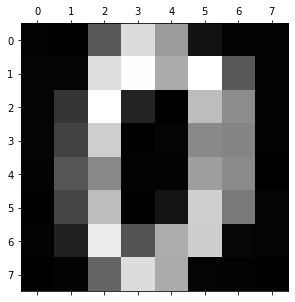

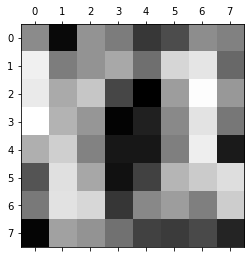

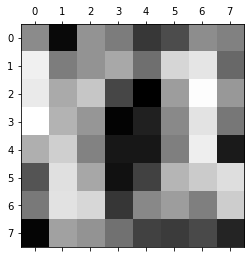

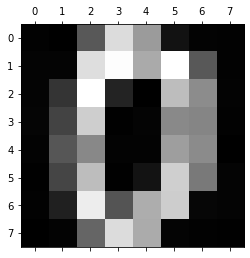

In [6]:
from matplotlib import pyplot as plt

plt.matshow(X_noisy_flat[0].reshape(8, 8), cmap='gray')
plt.show()
plt.matshow(X_ecdf[0].reshape(8, 8), cmap='gray')
plt.show()
plt.matshow(scs.norm.cdf(X_gaussian[0].reshape(8, 8)), cmap='gray')
plt.show()
plt.matshow(reverse_transform(X_gaussian[0]), cmap='gray')
plt.show()

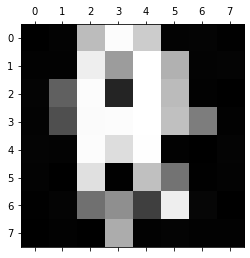

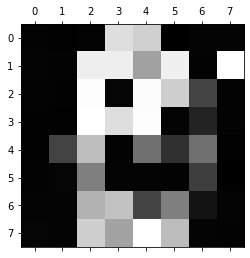

In [41]:
noise_test = torch.randn(100000, 1, 8, 8)
r_noise = model(noise_test)
idx_sim = np.argmax(r_noise.detach().numpy())
plt.matshow(reverse_transform(noise_test[idx_sim].squeeze()), cmap='gray')
plt.show()
plt.matshow(reverse_transform(noise_test[0].squeeze()), cmap='gray')

In [15]:

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        r_p = model(inputs).squeeze()  
        r_q = model(torch.randn((10*inputs.shape[0],1,8,8))).squeeze()      
        loss = loss_nce(r_p, r_q,inputs.shape[0], 10*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/500, Loss: 0.28337567646441786
Epoch 2/500, Loss: 0.27360423782776144
Epoch 3/500, Loss: 0.3806791377478632
Epoch 4/500, Loss: 0.25442612787772867
Epoch 5/500, Loss: 0.24589012588920264
Epoch 6/500, Loss: 0.280538825414561
Epoch 7/500, Loss: 0.2559615368473119
Epoch 8/500, Loss: 0.26065607381791905
Epoch 9/500, Loss: 0.2712930902067957
Epoch 10/500, Loss: 0.2601696327328682
Epoch 11/500, Loss: 0.315560935386296
Epoch 12/500, Loss: 0.24228072320592814
Epoch 13/500, Loss: 0.2625442686779746
Epoch 14/500, Loss: 0.24811155400399504
Epoch 15/500, Loss: 0.2764718625052222
Epoch 16/500, Loss: 0.2883329450570304
Epoch 17/500, Loss: 0.2537659951084261
Epoch 18/500, Loss: 0.23751358238273654
Epoch 19/500, Loss: 0.23414004260096058
Epoch 20/500, Loss: 0.2385107659702671
Epoch 21/500, Loss: 0.274382500299092
Epoch 22/500, Loss: 0.29644268821796466
Epoch 23/500, Loss: 0.2803063053509285
Epoch 24/500, Loss: 0.22574012354016304
Epoch 25/500, Loss: 0.2529170821452963
Epoch 26/500, Loss: 0.2521

In [220]:
import torch
import numpy as np
from pyhmc import hmc
from scipy.special import logsumexp

def sample_from_model(model, n_samples, hmc_runs=5, burn_in_n=1000, bimodal_hmc=False):
    def log_r_times_gauss(x):
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        fun = torch.log(model(x_tensor)).sum() + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    def sample_ratio_IS(model, n_prop, n_out):
        z = np.random.randn(n_prop, 1, 8, 8)
        r_log = np.log(model(torch.tensor(z).float()).detach().numpy()).sum(axis=(1, 2, 3)) + \
                torch.distributions.Normal(0, 1).log_prob(torch.tensor(z).float()).sum(axis=(1, 2, 3)).detach().numpy()
        sims = np.random.choice(np.arange(n_prop), size=n_out, p=np.exp(r_log - logsumexp(r_log)).flatten(), replace=True)
        return z[sims]

    samples = []
    log_pdf_samples = []
    for hmc_run in range(hmc_runs):
        start_x = sample_ratio_IS(model, 100, 10)
        if bimodal_hmc:
            samples1 = hmc(log_r_times_gauss, x0=start_x[0], n_samples=int(n_samples/2), return_logp=True, n_burn=burn_in_n)
            samples2 = hmc(log_r_times_gauss, x0=-start_x[0], n_samples=int(n_samples/2), return_logp=True, n_burn=burn_in_n)
            samples.append(np.concatenate([samples1[0], samples2[0]]))
            log_pdf_samples.append(np.concatenate([samples1[1], samples2[1]]))
        else:
            samples1 = hmc(log_r_times_gauss, x0=start_x[0], n_samples=n_samples, return_logp=True, n_burn=burn_in_n)
            samples.append(samples1[0])
            log_pdf_samples.append(samples1[1])

        print('run', hmc_run, 'DONE')

    samples = np.concatenate(samples)
    log_pdf_samples = np.concatenate(log_pdf_samples)
    return samples, log_pdf_samples

# Example usage
n_runs = 1
n_sims = 2
samples, log_pdf_samples = sample_from_model(model, n_sims, hmc_runs=n_runs, burn_in_n=3, bimodal_hmc=True)
print(samples.shape)

AxisError: axis 2 is out of bounds for array of dimension 2

### MNIST 784d

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot

# Define a classifier for MNIST images
class Classifier_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28)):
        super(Classifier_MNIST, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define model
model = Classifier_MNIST()

# Print model summary
summary(model, (1, 28, 28))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Example input for visualization
x = torch.randn(1, 1, 28, 28)
y = model(x)

# Plot the model
make_dot(y, params=dict(model.named_parameters())).render("discriminator_plot", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                    [-1, 1]           3,137
           Sigmoid-9                    [-1, 1]               0
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
---------------------------------------------

'discriminator_plot.png'